In [2]:
import pandas as pd



In [3]:
df1 = pd.read_excel("Diabetes Data.xlsx")
df2 = pd.read_excel("PreDiabetes Data.xlsx")

In [4]:
# Assuming df1 = Diabetic, df2 = Prediabetic
df1['Class'] = 1  # Diabetic
df2['Class'] = 0  # Prediabetic

# Keep common columns only
common_cols = df1.columns.intersection(df2.columns)
df1 = df1[common_cols]
df2 = df2[common_cols]

# Combine the datasets
df = pd.concat([df1, df2], ignore_index=True)


In [5]:
drop_cols = ['Name', 'policy_id', 'Address', 'Contact No.', 'Last_visit_date',
             'gps_id', 'Location_id','Education(Std)','Occupation']

df = df.drop(columns=[col for col in drop_cols if col in df.columns])


In [6]:
binary_cols = ['In RRA too', 'Tobacco_current', 'Smoking_current', 'Alcohol']

for col in binary_cols:
    if col in df.columns:
        # First replace NaN with 'Unknown'
        df[col] = df[col].fillna('Unknown')

        # Then map 'y' to 1, 'n' to 0, 'Unknown' to -1
        df[col] = df[col].map({'y': 1, 'n': 0, 'Unknown': -1})


# Now safely fill numeric columns with median
numeric_cols = ['Age', 'FBS', 'height', 'weight', 'BMI', 'wc',
                '# members_in_household', 'Amount spent', 'visit_id(last)']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # force numeric
        df[col] = df[col].fillna(df[col].median())


In [7]:
if 'Hc' in df.columns:
    if df['Hc'].isnull().sum() / len(df) > 0.2:  # If >20% missing, drop it
        df = df.drop(columns=['Hc'])
    else:
        df['Hc'] = df['Hc'].fillna(df['Hc'].median())

In [8]:
# Encode Gender column (M/F → 1/0)
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})

# One-Hot Encoding for multi-category columns
cat_cols = ['RMHC', 'Village','Gender']
for col in cat_cols:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [9]:
df.head()

,In RRA too,visit_id(last),Hyperlipidemia+Diabetes,Age,FBS,height,weight,BMI,wc,Hc,...,# members_in_household,Amount spent,Class,RMHC_RMHC Andipatti,RMHC_RMHC Arunthavapuram,RMHC_RMHC Karambayam,RMHC_RMHC Kavarapattu,RMHC_RMHC Okkanadu Melaiyur,RMHC_RMHC Ponnapur,Gender_1.0
0,1,3336039.0,NaN,44.479124,159.0,155.0,83.0,0.535484,105.0,114.0,...,5.0,242.50,1,True,False,False,False,False,False,False
1,1,3341521.0,0.0,50.480493,205.6,158.0,66.0,0.417722,92.0,96.0,...,6.0,4638.20,1,True,False,False,False,False,False,True
2,1,3340642.0,0.0,51.909651,240.0,160.0,72.0,0.450000,74.0,80.0,...,5.0,119.75,1,True,False,False,False,False,False,True
3,1,3341479.0,0.0,32.479124,129.0,154.0,78.0,0.506494,108.0,91.0,...,6.0,212.00,1,True,False,False,False,False,False,True
4,1,3341560.0,0.0,72.479124,126.4,146.0,56.0,0.383562,88.0,91.0,...,5.0,572.50,1,True,False,False,False,False,False,False


In [10]:
# Split data into features (X) and target (y)
X = df.drop('Class', axis=1)  # Features are all columns except 'Class'
y = df['Class']  # Target is the 'Class' column

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.8807339449541285

📊 Confusion Matrix:
 [[40  5]
 [ 8 56]]

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        45
           1       0.92      0.88      0.90        64

    accuracy                           0.88       109
   macro avg       0.88      0.88      0.88       109
weighted avg       0.88      0.88      0.88       109



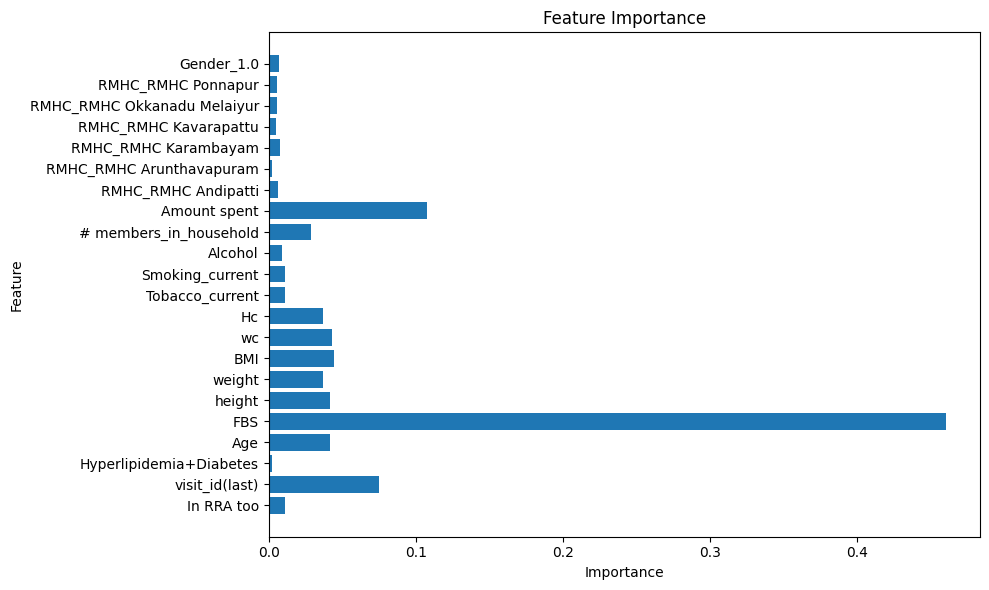

In [14]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

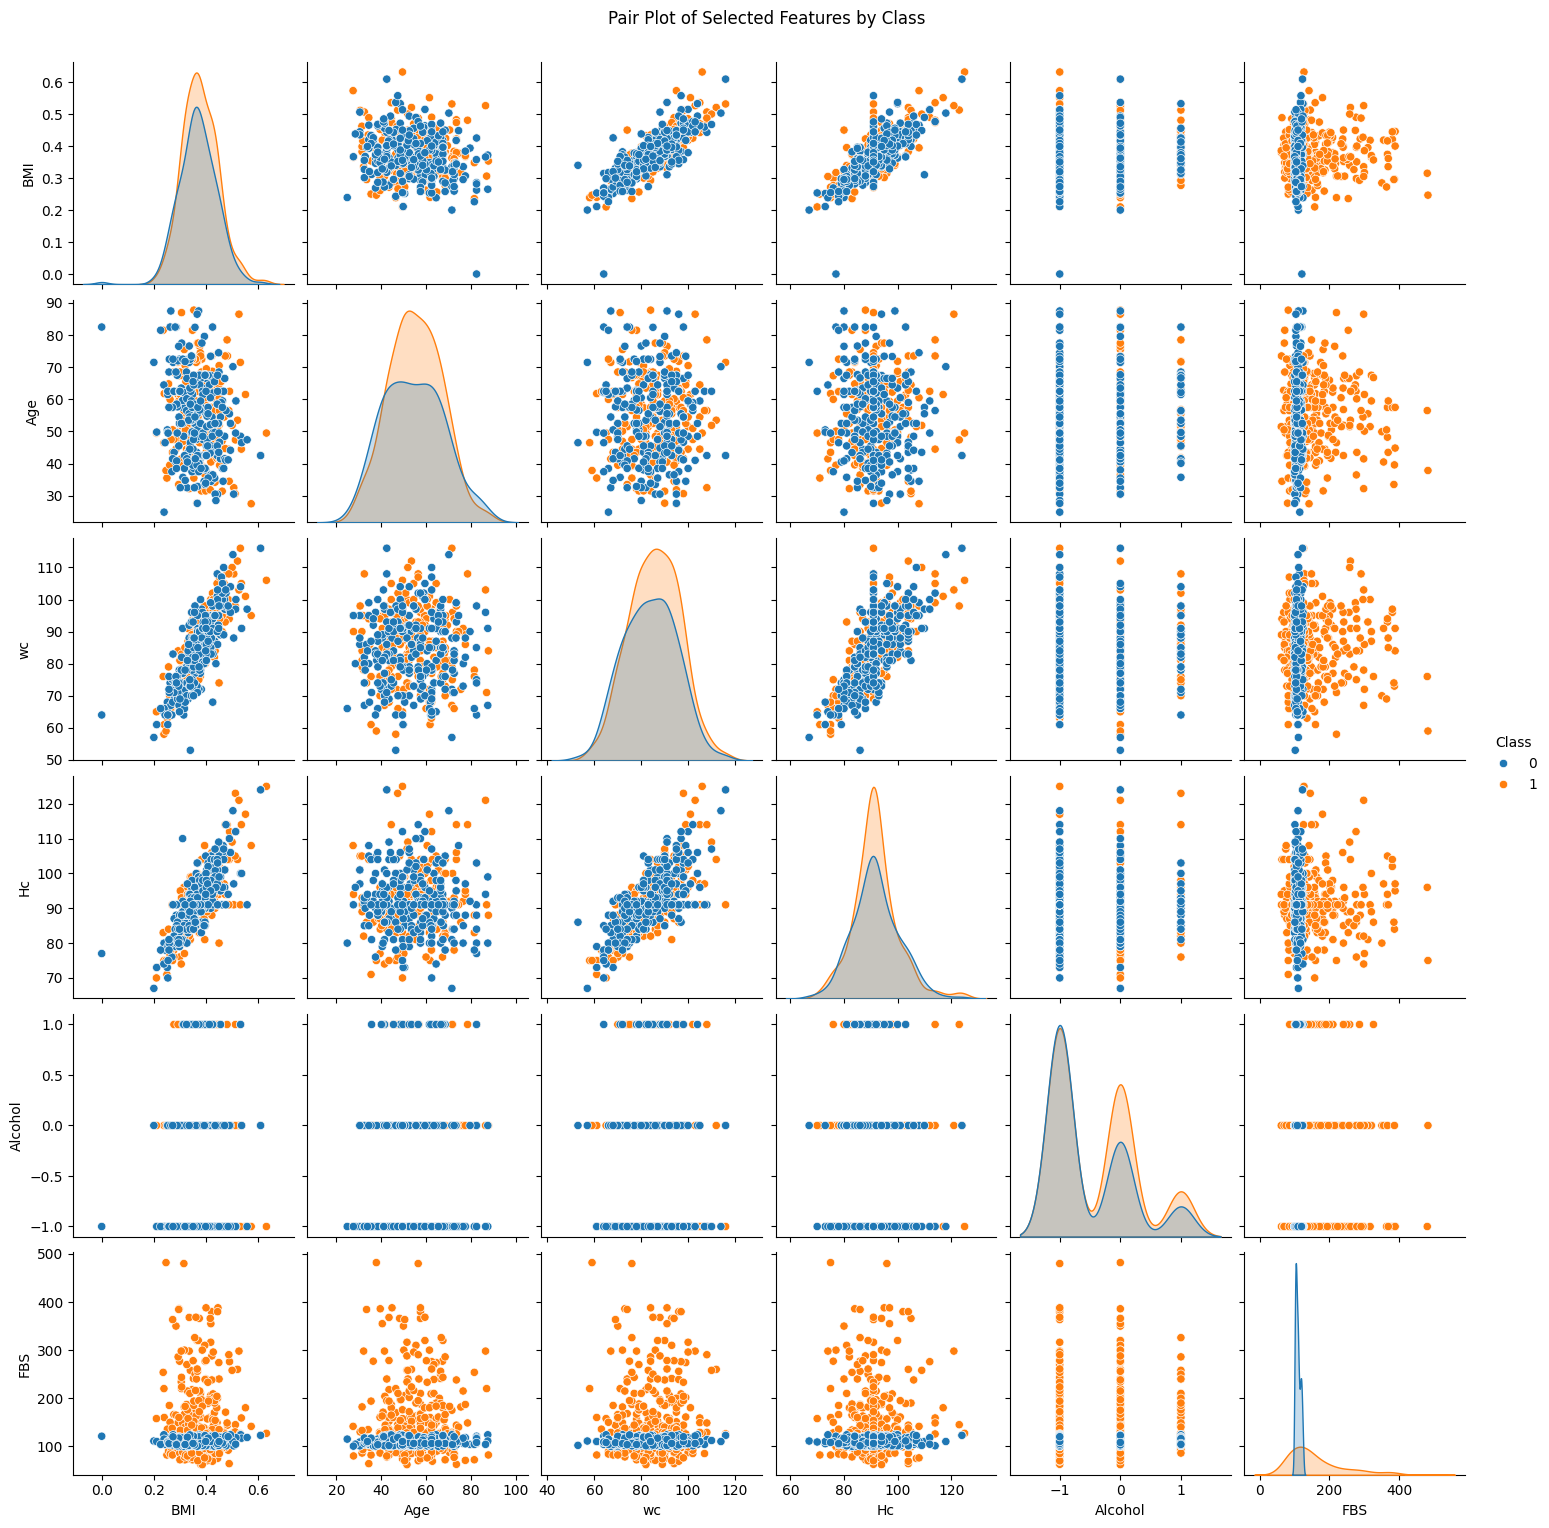

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate pair plot for the relevant features
# Using a subset of features for clarity and performance
features_for_pairplot = ['BMI', 'Age', 'wc', 'Hc', 'Alcohol', 'FBS', 'Class']
sns.pairplot(df[features_for_pairplot], hue='Class', diag_kind='kde')
plt.suptitle("Pair Plot of Selected Features by Class", y=1.02)
plt.show()

In [17]:
features = ['BMI', 'Age', 'wc','Hc','Alcohol','FBS']
X = df[features]
y = df['Class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best accuracy found:  0.9193270120259018


In [21]:
from sklearn.metrics import classification_report

y_pred_best_xgb = best_xgb_model.predict(X_test)
print("🧾 Classification Report for Best XGBoost Model:\n", classification_report(y_test, y_pred_best_xgb))

🧾 Classification Report for Best XGBoost Model:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92        45
           1       0.98      0.89      0.93        64

    accuracy                           0.93       109
   macro avg       0.92      0.93      0.93       109
weighted avg       0.93      0.93      0.93       109



In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict probabilities for the test set
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Apply custom threshold
threshold = 0.4  # Example threshold value
y_pred_thresh = (y_proba >= threshold).astype(int)


print("✅ Accuracy with threshold:", accuracy_score(y_test, y_pred_thresh))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred_thresh))

✅ Accuracy with threshold: 0.8532110091743119

📊 Confusion Matrix:
 [[34 11]
 [ 5 59]]

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81        45
           1       0.84      0.92      0.88        64

    accuracy                           0.85       109
   macro avg       0.86      0.84      0.85       109
weighted avg       0.85      0.85      0.85       109



In [23]:
import joblib

joblib.dump(grid_search, "xgboost_grid_search.joblib")

['xgboost_grid_search.joblib']

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Validation for best_xgb_model
y_pred_val = best_xgb_model.predict(X_test)

print("✅ Validation Accuracy:", accuracy_score(y_test, y_pred_val))
print("\n📊 Validation Confusion Matrix:\n", confusion_matrix(y_test, y_pred_val))
print("\n🧾 Validation Classification Report:\n", classification_report(y_test, y_pred_val))

✅ Validation Accuracy: 0.926605504587156

📊 Validation Confusion Matrix:
 [[44  1]
 [ 7 57]]

🧾 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92        45
           1       0.98      0.89      0.93        64

    accuracy                           0.93       109
   macro avg       0.92      0.93      0.93       109
weighted avg       0.93      0.93      0.93       109

